<a href="https://colab.research.google.com/github/simeonnalovski/NLP-Sentiment-Analysis-and-Text-Generation-in-Finance-/blob/main/NoFineTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install newsapi-python datasets


--- Evaluation Results for Combined Dataset ---
Accuracy: 0.1761
Precision: 0.2809
Recall: 0.1761
F1 Score: 0.2006


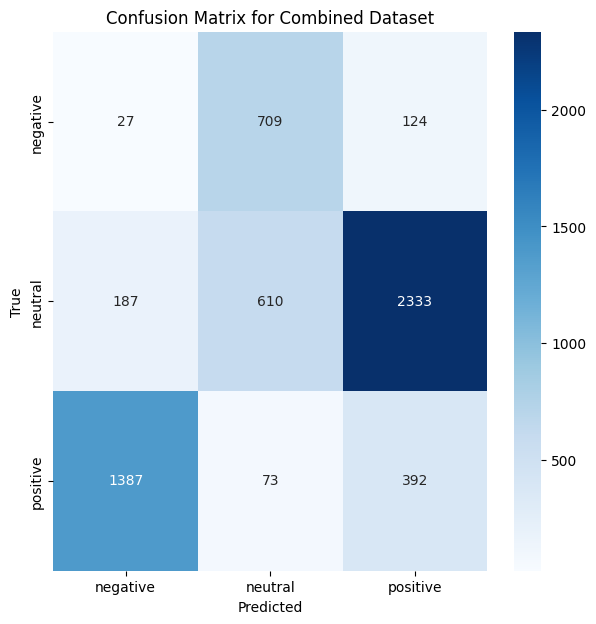

('/content/drive/MyDrive/models/raw_finbert/tokenizer_config.json',
 '/content/drive/MyDrive/models/raw_finbert/special_tokens_map.json',
 '/content/drive/MyDrive/models/raw_finbert/vocab.txt',
 '/content/drive/MyDrive/models/raw_finbert/added_tokens.json',
 '/content/drive/MyDrive/models/raw_finbert/tokenizer.json')

In [ ]:
import os
import torch
import pandas as pd
from datetime import datetime, timedelta, timezone
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# proverka za ured
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pateki
DATA_CSV_PATH = '/content/drive/MyDrive/data/data.csv'
MODEL_SAVE_PATH = '/content/drive/MyDrive/models/raw_finbert'

# gotov model
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3).to(device)

# klasa dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label)
        }

# citanje i obrabotka na podatoci
try:
    df = pd.read_csv(DATA_CSV_PATH)
    if 'Sentence' not in df.columns or 'Sentiment' not in df.columns:
        raise ValueError("CSV file must contain 'Sentence' and 'Sentiment' columns.")

    all_texts = df['Sentence'].tolist()
    all_sentiments = df['Sentiment'].tolist()
    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    all_labels = []
    filtered_all_texts = []
    for i, s in enumerate(all_sentiments):
        if s.lower() in sentiment_map:
            all_labels.append(sentiment_map[s.lower()])
            filtered_all_texts.append(all_texts[i])
        else:
            print(f"Warning: Skipping row with unrecognized sentiment '{s}'")
    full_dataset = SentimentDataset(filtered_all_texts, all_labels, finbert_tokenizer)
    full_dataloader = DataLoader(full_dataset, batch_size=16, shuffle=False)

except FileNotFoundError:
    print(f"Error: CSV file not found at {DATA_CSV_PATH}")
    exit()
except ValueError as e:
    print(f"Error: {e}")
    exit()

# funkcija za evaluacija
def evaluate(model, dataloader, dataset_name="Full Dataset"):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().tolist()
            true_labels.extend(labels.cpu().tolist())
            predicted_labels.extend(predictions)

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

    print(f"\n--- Evaluation Results for {dataset_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    labels_order = list(sentiment_map.keys())
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(sentiment_map.values()))
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.show()

# evaluacija
evaluate(finbert_model, full_dataloader, dataset_name="Combined Dataset")
finbert_model.save_pretrained(MODEL_SAVE_PATH)
finbert_tokenizer.save_pretrained(MODEL_SAVE_PATH)

pytorch_model.bin:  42%|####1     | 1.03G/2.45G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



 Stock: NVDA
Mean sentiment score (No-tuned FinBERT): 1.1100
Total sentiment score: 111
Sentiment category: neutral
Data saved to: /content/drive/MyDrive/data/stock_sentiment.csv

 Evaluating  FinBERT agains RoBertA-labeled news
 Accuracy:   0.2100
 Precision:  0.2513
 Recall:     0.2100
 F1 Score:   0.2262


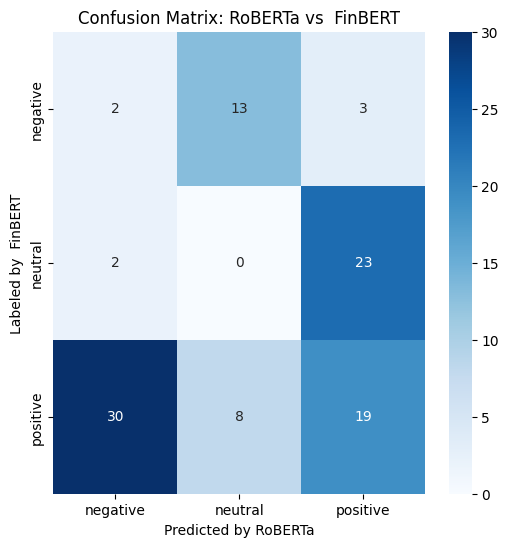

In [ ]:
# --- CELL 2: Predict Sentiment of Fetched News and Evaluate Against RoBERTa ---
import os
import torch
import pandas as pd
from datetime import datetime, timedelta, timezone
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from newsapi import NewsApiClient
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OUTPUT_PATH = '/content/drive/MyDrive/data/stock_sentiment.csv'
NEWS_API_KEY = "37f8e9b2659445db81c4a404bafcd36c"
STOCK_SYMBOL = "NVDA"


finbert_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
finbert_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH).to(device)
finbert_model.eval()


roberta_pipe = pipeline("text-classification", model="soleimanian/financial-roberta-large-sentiment")
newsapi = NewsApiClient(api_key=NEWS_API_KEY)

def fetch_recent_news(stock_symbol):
    end_date = datetime.now(timezone.utc)
    start_date = max(end_date - timedelta(days=28))
    articles = newsapi.get_everything(
        q=stock_symbol,
        from_param=start_date.strftime('%Y-%m-%d'),
        to=end_date.strftime('%Y-%m-%d'),
        language='en',
        sort_by='relevancy',
        page_size=100,
        page=1
    )
    return [article["title"] for article in articles.get("articles", []) if article["title"]]


def classify_with_finbert(texts, tokenizer, model, device, batch_size=16):
    results = []
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    for i in range(0, len(texts), batch_size):
        batch = texts[i: i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).tolist()
        results.extend(predictions)
    return [label_map[p] for p in results]


def classify_with_roberta(texts):
    preds = roberta_pipe(texts, truncation=True, padding=True)
    return [p["label"].lower() for p in preds]

def get_sentiment_category(mean_score):
    normalized_score = mean_score / 2
    if normalized_score < 0.3:
        return "negative"
    elif normalized_score < 0.7:
        return "neutral"
    else:
        return "positive"

# evaluacija 2
def evaluate_models(df):
    predicted_labels = df["finbert_label"].tolist()
    true_labels = df["roberta_label"].tolist()

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average="weighted")

    print("\n Evaluating  FinBERT agains RoBertA-labeled news")
    print(f" Accuracy:   {accuracy:.4f}")
    print(f" Precision:  {precision:.4f}")
    print(f" Recall:     {recall:.4f}")
    print(f" F1 Score:   {f1:.4f}")

    labels_order = ["negative", "neutral", "positive"]
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted by RoBERTa")
    plt.ylabel("Labeled by  FinBERT")
    plt.title("Confusion Matrix: RoBERTa vs  FinBERT")
    plt.show()

# --- MAIN EXECUTION ---


titles = fetch_recent_news(STOCK_SYMBOL)
if not titles:
    raise ValueError(f"No recent news found for {STOCK_SYMBOL}")

finbert_labels = classify_with_finbert(titles, finbert_tokenizer, finbert_model, device)
roberta_labels = classify_with_roberta(titles)

df = pd.DataFrame({
    "headline": titles,
    "stock": STOCK_SYMBOL,
    "finbert_label": finbert_labels,
    "roberta_label": roberta_labels
})

# oceni
sentiment_score_map = {"negative": 0, "neutral": 1, "positive": 2}
df["score"] = df["finbert_label"].map(sentiment_score_map)
mean_sentiment = df["score"].mean()
total_sentiment = df["score"].sum()
sentiment_category = get_sentiment_category(mean_sentiment)

# zacuvuvanje na rezultati
new_entry = pd.DataFrame([{ "stock": STOCK_SYMBOL, "mean_sentiment": mean_sentiment, "total_sentiment": total_sentiment,
                           "sentiment": sentiment_category }])
if os.path.exists(OUTPUT_PATH):
    existing_df = pd.read_csv(OUTPUT_PATH)
    existing_df = existing_df[existing_df["stock"] != STOCK_SYMBOL]
else:
    existing_df = pd.DataFrame(columns=["stock", "mean_sentiment", "total_sentiment", "sentiment"])

updated_df = pd.concat([existing_df, new_entry], ignore_index=True)
updated_df.to_csv(OUTPUT_PATH, index=False)

# izlez
print(f"\n Stock: {STOCK_SYMBOL}")
print(f"Mean sentiment score (No-tuned FinBERT): {mean_sentiment:.4f}")
print(f"Total sentiment score: {total_sentiment}")
print(f"Sentiment category: {sentiment_category}")
print(f"Data saved to: {OUTPUT_PATH}")
evaluate_models(df)